# Image Dehazing and Guided Filtering

In [7]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files

## Dark Channel Prior
The basis of this image dehazing technique is called the dark channel prior which is an assumtion based on the statistics of haze free images. This assumtion simply states that for a given local region of an image that does not contain sky, the minimum channel intensity of the pixels in that region will be very low. The theory is that for a hazy image, any intensity that this "dark pixel" has can be attributed to the haze in that region and can therefore be used to estimate the transmissivity of the atmosphere in every region of the image.

### Dark Channel Image


To use the dark channel prior to analyze an image we must compute the "dark channel" of the image. The concept of a dark channel image is very similar to the concept of min-filtering an image with the differerence being that all the channels of the local neighborhood are considered independent. For this implementation we generate the dark channel image by min-filtering the image with a 15x15x3 kernel where the dimension with size 3 corresponds with the channels of the image.
<br>
<br>
$$J^{dark}(x) = \min_{c∈{r,g,b}}(\min_{y∈Ω(x)}(J_c(y)))$$
<br>
Where J<sub>c</sub> is the color channel of J and Ω(x) is the local patch centered at x

In [2]:
# Jackie
def darkChannel(img, ps=15):
    '''
    Calculate Dark Channel of an RGB Image
    '''
    half_width = int(ps/2)
    impad = np.pad(img, [(half_width,half_width), (half_width,half_width) , (0,0)], 'edge')
    
    dark = np.zeros((img.shape[0],img.shape[1]))
    
    for i in range(half_width, (img.shape[0]+half_width)):
        for j in range(half_width, (img.shape[1]+half_width)):
            patch = impad[i-half_width:i+1+half_width, j-half_width:j+1+half_width]
            dark[i-half_width, j-half_width] = np.min(patch)
    
    return dark

### Example of Dark Channel Prior
For a hazy image the dark channel closely esimates the haze coverage of the scene. For a non-hazy image the dark channel appears almost completely black, indicating that there is no haze in the image

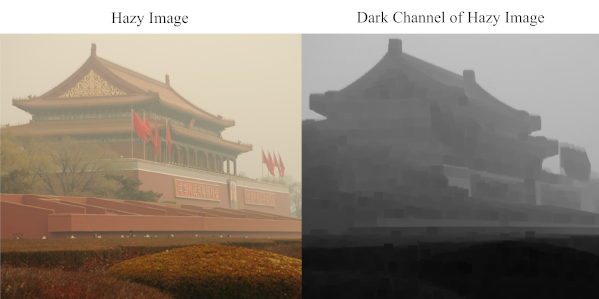






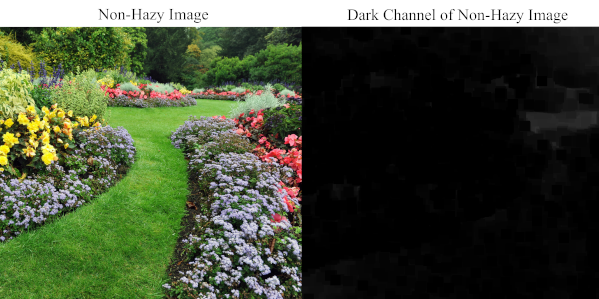

### Estimating Atmospheric Transmission from the Dark Channel


Generating a map of atmospheric transmission across the image is closely related to the dark channel of the image. To generate a transmision map all that is required is to scale the dark channel by the global atmospheric light and perform a weighted inverse. The paper suggests using a weight of 0.95 on the dark channel scaled by the global atmospheric light to retain some of the distant haze.
<br>
<br>
$$ \tilde{t}(x) = 1 - ω\min_{c∈{r,g,b}}(\min_{y∈Ω(x)}(\frac{I_c(y)}{A_c}))$$
<br>
Where ω is the weight value, A<sub>c</sub> is the global atmospheric light and I<sub>c</sub> is the original image

In [30]:
# Jackie
def transmission(img, A, w=0.95):
  '''
  Estimation of Atmospheric Transmission Map
  '''
  nimg = np.zeros(img.shape)
    
  for c in range(0, img.shape[2]):
      nimg[:,:,c] = img[:,:,c]/A[c]
    
  # estimate the dark channel of the normalized haze image
  dark = darkChannel(nimg)
    
  # calculates the transmisson t
  t = 1-w*dark+0.1
    
  return t

### Estimating Global Atmospheric Light

The global atmospheric light of the image is a color/intensity value that can be attributed to illumination of the image caused by the atmosphere, independent of the haze. When performing image dehazing we want to identify an estimate of this value so that we can avoid distorting the natural illumination of the image. To estimate this parameter, we first identify the top 0.1% highest intensity pixels of the dark channel. We then choose the highest intensity pixel value in the original image that corresponds with these pixel locations as the global atmospheric light estimation.

In [25]:
# Jackie
def atmLight(img, dark, px=1e-3):
    '''
    Estimation of Global Atmospheric Light
    '''
    imgavec = np.resize(img, (img.shape[0]*img.shape[1], img.shape[2]))
    jdarkvec = np.reshape(dark, dark.size)
    
    numpx = int(dark.size * px)
    
    isjd = np.argsort(-jdarkvec)

    asum = np.zeros((3), dtype=np.float32)
    for i in range(0, numpx):
        asum[:] += imgavec[isjd[i], :]
  
    A = np.zeros((3), dtype=np.float32)
    A[:] = asum[:]/numpx
  
    return A

## Refining the Atmospheric Transmission Map

### Motivation
Directly calculating the transmission map using the procedure above results in a blocky image that does not closely replicate the contours of the original image. This is because the process of extracting the dark channel considers a relatively large neighborhood when calculating pixel values and therefore does not preserve image edges well. For best results, we need to find a way to refine the raw transmission map in a way that better preserves the original image edges




### Guided Filtering
Guided filtering is a technique that has this edge refining property that we are looking for without the need to implement the complex and computationally inefficient optimization procedure suggested in the research paper. 


The procedure of guided filtering is very interesting and relatively simple conceptually. The goal of guided filtering is refine an input image p with the help of a guidance image I which contains the desired edge properties. The main constraint for guided filtering is that the output image q must be a linear transform of I within a local neighborhood.
<br>
<br>
$$ q_i = a_k I_i + b_k, \forall i \in \omega_k $$
<br>
To determine the linear coefficients (a<sub>k</sub>, b<sub>k</sub>), guided filtering seeks a solution that minimizes the difference between the output image window q<sub>i</sub> and the input image window p<sub>i</sub>. Explicitly it minimizes this cost function:

$$ E(a_k, b_k) = \sum_{i \in \omega_k} ((a_k I_i + b_k - p_i)^2 + \epsilon a_k^2) $$

Where ϵ is a regularization that limits the magnitude of *a*. This solution to this cost function can be found by linear regression.

$$ a_k = \frac{\frac{1}{|\omega|}∑_{i\in \omega_k}I_ip_i-\mu_k\bar{p}_k}{\sigma_k^2 + \epsilon} $$

$$b_k = \bar{p}_k - a_k\mu_k$$

Where μ<sub>k</sub> and σ<sub>k</sub> are the mean and standard deviation if I in ω<sub>k</sub>, |ω| is the number of pixels in ω<sub>k</sub>, and p̄ is the mean of p in ω<sub>k</sub>. To process all of the overlapping windows generated by this process into a final ouput image we take the average of all overlapping pixel values.

### Results When Applied to Transmission Map

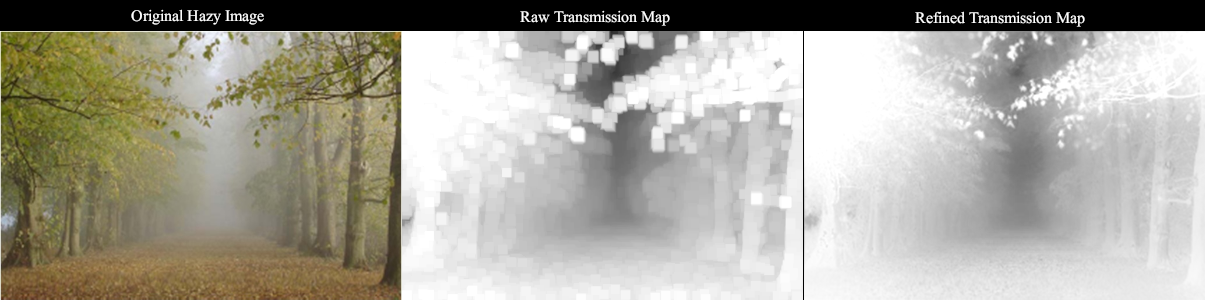

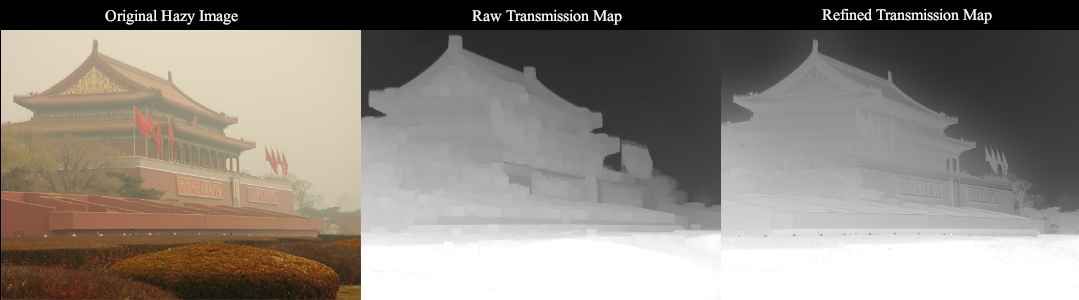

## Other Uses of Guided Filtering
**Image Smoothing While Preserving Edges**
<br>
Input a blurred version of an image with the original image as the guidance image. This has a similar effect to a image processing technique called bilateral filtering. The result is an image with major edges preserved while noise and less significant edges are eliminated.


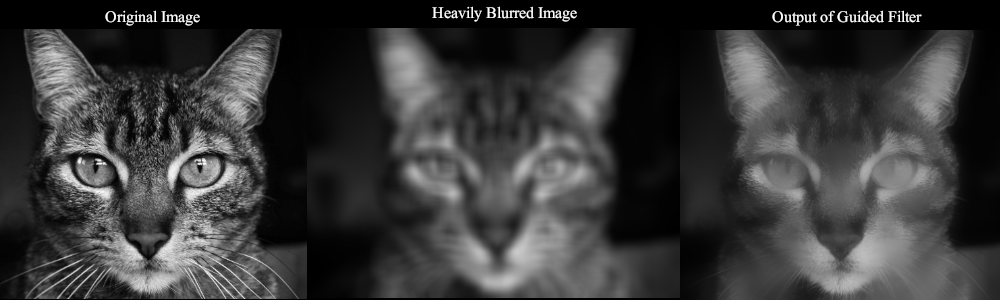

**Guideded Feathering for a Binary Mask**
<br>
Input a binary mask of representing a rough contour of an object in an image with the original image for guidance. This results in a feathered alpha map that can capture fine edge detail such as hair that is usually tough/impractical to capture with a binary mask.

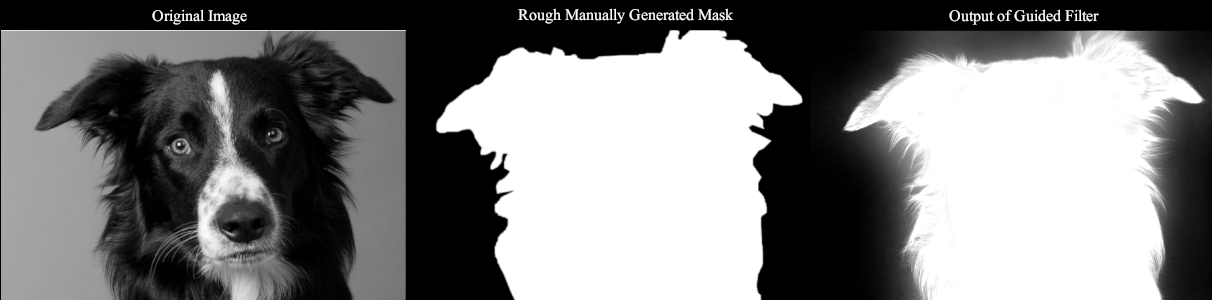

## Implementation

In [22]:
# Brycen
def guidedFilter(img, p, r=40, e=1e-3):
    '''
    Guided Filter Implementation
    '''
    H, W, C = img.shape 
    #S is a matrix with the sizes of each local patch (window wk)
    S = boxfilter(np.ones((H, W)), r)
    
    #the mean value of each channel in img
    mean_i = np.zeros((C, H, W))
    
    for c in range(0, C):
        mean_i[c] = boxfilter(img[:,:, c], r)/S
    
    #the mean of the guided filter p
    mean_p = boxfilter(p, r)/S
    
    mean_ip = np.zeros((C, H, W))
    for c in range(0, C):
        mean_ip[c] = boxfilter(img[:,:,c]*p, r)/S
    
    cov_ip = np.zeros((C, H, W))
    for c in range(0, C):
        cov_ip[c] = mean_ip[c] - mean_i[c]*mean_p
    

    #The variance in each window is a 3x3 symmetric matrix with variance as its values:
    #           rr, rg, rb
    #   sigma = rg, gg, gb
    #           rb, gb, bb
    var_i = np.zeros((C, C, H, W))
    #variance of (R, R)
    var_i[0, 0] = boxfilter(img[:,:,0]*img[:,:,0], r)/S - mean_i[0]*mean_i[0]
    #variance of (R, G)
    var_i[0, 1] = boxfilter(img[:,:,0]*img[:,:,1], r)/S - mean_i[0]*mean_i[1]
    #variance of (R, B)
    var_i[0, 2] = boxfilter(img[:,:,0]*img[:,:,2], r)/S - mean_i[0]*mean_i[2]
    #variance of (G, G)
    var_i[1, 1] = boxfilter(img[:,:,1]*img[:,:,1], r)/S - mean_i[1]*mean_i[1]
    #variance of (G, B)
    var_i[1, 2] = boxfilter(img[:,:,1]*img[:,:,2], r)/S - mean_i[1]*mean_i[2]
    #variance of (B, B)
    var_i[2, 2] = boxfilter(img[:,:,2]*img[:,:,2], r)/S - mean_i[2]*mean_i[2]
    
    a=np.zeros((H,W,C))
    
    for i in range(0, H):
        for j in range(0, W):
            sigma = np.array([ [var_i[0, 0, i, j], var_i[0, 1, i, j], var_i[0, 2, i, j]], 
                                  [var_i[0, 1, i, j], var_i[1, 1, i, j], var_i[1, 2, i, j]],
                                  [var_i[0, 2, i, j], var_i[1, 2, i, j], var_i[2, 2, i, j]]])
            

            cov_ip_ij = np.array([ cov_ip[0, i, j], cov_ip[1, i, j], cov_ip[2, i, j]])
            
            a[i, j] = np.dot(cov_ip_ij, np.linalg.inv(sigma + e*np.identity(3)))
    
    b = mean_p - a[:,:,0]*mean_i[0,:,:] - a[:,:,1]*mean_i[1,:,:] - a[:,:,2]*mean_i[2,:,:] 


    pp = ( boxfilter(a[:,:,0], r)*img[:,:,0]
          +boxfilter(a[:,:,1], r)*img[:,:,1]
          +boxfilter(a[:,:,2], r)*img[:,:,2]
          +boxfilter(b, r) )/S
    
    return pp


def boxfilter(m, r):
    # Reference: https://fukushima.web.nitech.ac.jp/paper/2017_iwait_nakamura.pdf
    """
    Fast box filtering implementation, O(1) time.
    """
    h, w = m.shape
    output = np.zeros(m.shape) 
    
    #cumulative sum over y axis
    ysum = np.cumsum(m, axis=0) 
    output[0:r+1, : ] = ysum[r:(2*r)+1, : ]
    output[r+1:h-r, : ] = ysum[(2*r)+1: , : ] - ysum[ :h-(2*r)-1, : ]
    output[(-r): , : ] = np.tile(ysum[-1, : ], (r, 1)) - ysum[h-(2*r)-1:h-r-1, : ]

    #cumulative sum over x axis
    xsum = np.cumsum(output, axis=1)
    output[ : , 0:r+1] = xsum[ : , r:(2*r)+1]
    output[ : , r+1:w-r] = xsum[ : , (2*r)+1: ] - xsum[:, :w-(2*r)-1]
    output[ : , -r: ] = np.tile(xsum[ : , -1][:, None], (1, r)) - xsum[ : , w-(2*r)-1:w-r-1]

    return output

### Dehazed Image Formation

The process of dehazing the image is a simple procedure of scaling the hazy image by the transmission map independent of the global atmospheric light

$$J(x) = \frac{I(x) - A}{max(t, t_0)} + A$$

Where *I(x)* is the hazy image, *J(x)* is the output dehazed image, A is the global atmospheric light, and *t* is the refined transmission map. The max operation between *t* and constant *t<sub>0* is taken to avoid very large values in the output.

In [6]:
# Brycen
def recover(img, A, t, tmin=0.1):
    """
    Recover dehazed image using estimations of transmission map and global atmospheric light
    """
    j = np.zeros(img.shape)
    
    for c in range(img.shape[2]):
        j[:,:, c] = ((img[:,:,c] - A[c]) / np.maximum(t[:,:], tmin)) + A[c]
    
    return j/np.max(j) # scale between 0 and 1

## Results

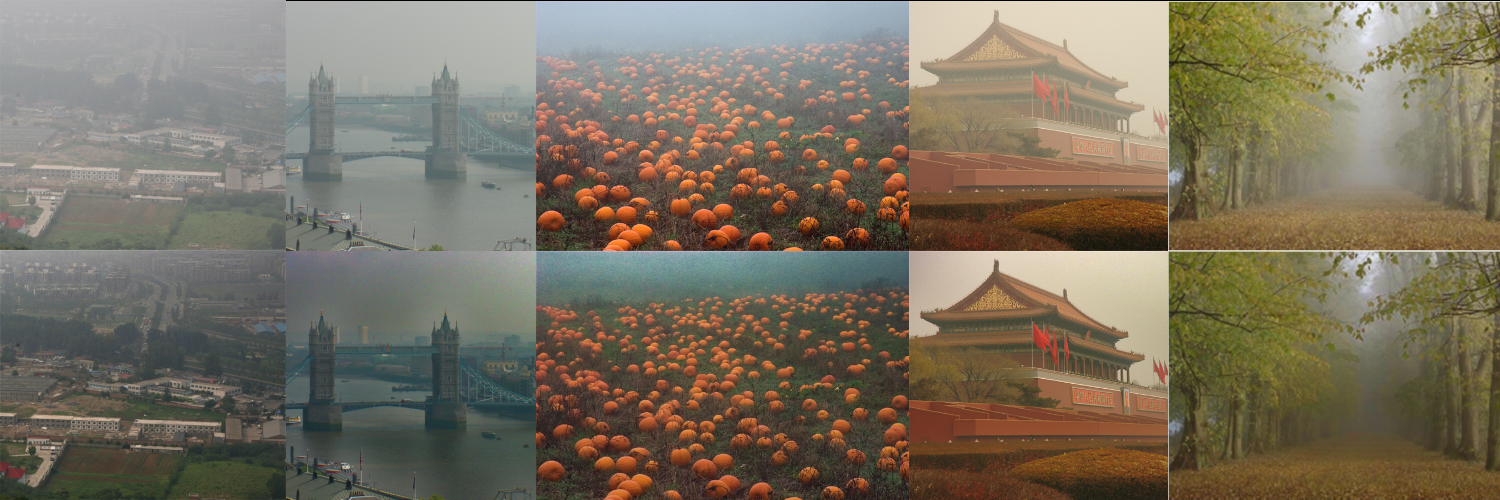

## Full Run Through of Algorithm



Saving tiananmen.png to tiananmen (3).png


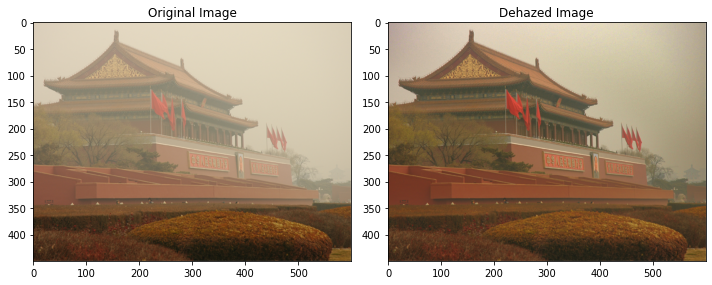

In [29]:
# Brycen
uploaded_file = files.upload()
filename = list(uploaded_file.keys())[0]
img = cv2.imread(filename)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) / 255.0

dark = darkChannel(img)
a = atmLight(img, dark)
rt = transmission(img, a)
rt = np.maximum(rt, 0.1)

t = guidedFilter(img, rt)

dehazed = recover(img, a, t, 0.1)

fig = plt.figure(figsize=(10, 16))
ax = fig.add_subplot(1, 2, 1)
ax.imshow(np.clip(img, 0, 1))
ax.set_title('Original Image')
ax = fig.add_subplot(1, 2, 2)
ax.imshow(dehazed / np.max(dehazed))
ax.set_title('Dehazed Image')
fig.tight_layout()
fig.show()

### References
[1] Kaiming He, Jian Sun and Xiaoou Tang, "Single image haze removal using dark channel prior," 2009 IEEE Conference on Computer Vision and Pattern Recognition, 2009, pp. 1956-1963, doi: 10.1109/CVPR.2009.5206515.

[2] K. He, J. Sun and X. Tang, "Guided Image Filtering," in IEEE Transactions on Pattern Analysis and Machine Intelligence, vol. 35, no. 6, pp. 1397-1409, June 2013, doi: 10.1109/TPAMI.2012.213.

[3] Nakamura, Masahiro, and Norishige Fukushima. "Fast implementation of box filtering." Proc. International Workshop on Advanced Image Technology (IWAIT). 2017.